## Reporte: Comparación de variables en poblaciones pediátricas y no pediátricas

Los archivos en esta carpeta permiten generar las ilustraciones y tablas asociados al reporte *Comparación de variables en poblaciones pediátricas y no pediátricas* realizado en el marco del proyecto FONDEF ID23I10423 
*Sistema informático en base a inteligencia artificial para predecir peak de hospitalizaciones pediátricas por causas respiratorias*.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA

In [2]:
dia_maximo = 365
USE_CUMSUM = True

grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
grupos_etarios_legends = ["Menores 1","De 1 a 4","De 5 a 14","De 15 a 64","De 65 y más"]

In [3]:
#read data from parquet file
#number of days from the beginning of the year to consider in the analysis

common_filter = """
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
and CodigoRegion is not null
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
group by CodigoDependencia, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(dia_maximo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'Menores_1' as grupo_etario
    , sum(Menores_1) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    ,'De_1_a_4' as grupo_etario
    , sum(De_1_a_4) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_5_a_14' as grupo_etario
    , sum(De_5_a_14) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_15_a_64'  as grupo_etario
    , sum(De_15_a_64) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_65_y_mas' as grupo_etario
    , sum(De_65_y_mas) as atenciones
"""+ common_filter + """
""").df()

df2 = df2.sort_values(by=['year','CodigoRegion','grupo_etario','nrodia']).reset_index(drop = True)

In [4]:
#the cumulative sum is taken on each of the classes, 
#is this case we group by "year", "CodigoRegion" and "grupo_etario"
#the result is a dataframe with the "nro_dia" in the columns, 
#in which the cumulative information of the demand, scaled from 0 to 1 is stored
groups = df2[["year","CodigoRegion","grupo_etario"]].drop_duplicates()
df_aux =df2.copy()
for (index, year, region, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoRegion'] == region) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','CodigoRegion','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()

In [5]:
#Analisis PCA

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(dia_maximo)]].values

# Separating out the target
y = df3.loc[:,['CodigoRegion','grupo_etario']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['CodigoRegion','grupo_etario']]], axis = 1)


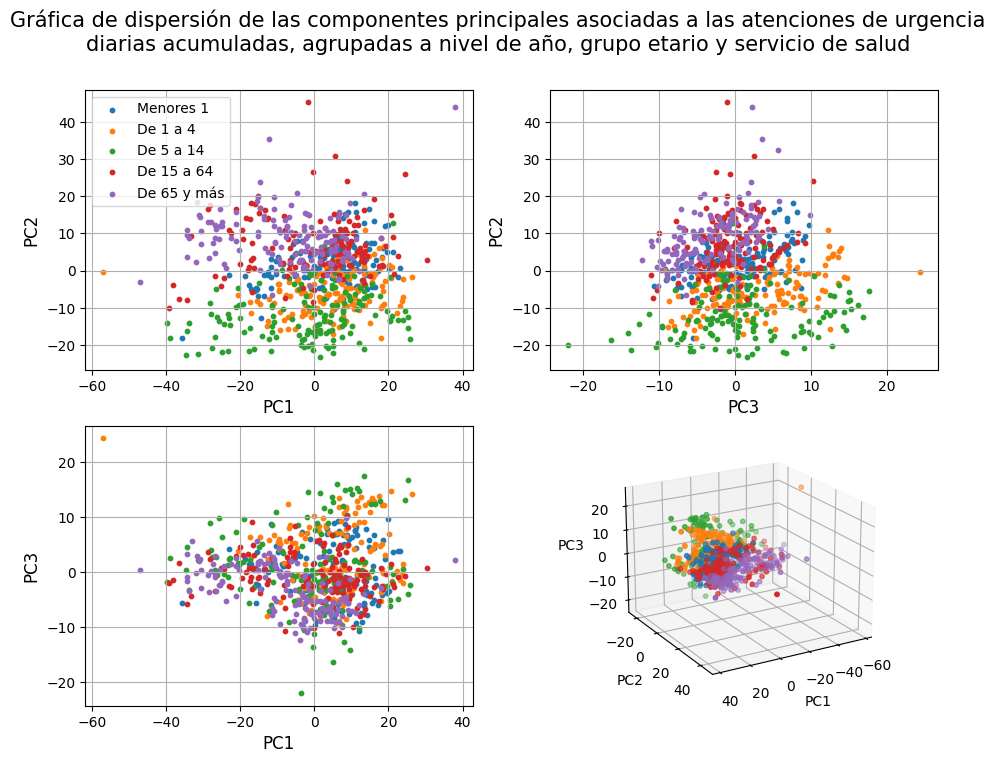

In [6]:
#Figura 7: componentes principales correspondientes a la separacion por año, servicio de salud y grupo etario
fig = plt.figure(figsize = (11,8))
fig.suptitle('Gráfica de dispersión de las componentes principales asociadas a las atenciones de urgencia\ndiarias acumuladas, agrupadas a nivel de año, grupo etario y servicio de salud', fontsize=15)

ax = fig.add_subplot(2,2,1) 
#ax.set_title('2 component PCA', fontsize = 20)
#ax.set_title('PC1 vs PC2', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in grupos_etarios:
    indicesToKeep = finalDf['grupo_etario'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()


ax.legend(grupos_etarios_legends)
    
ax = fig.add_subplot(2,2,2) 
#ax.set_title('PC1 vs PC3', fontsize = 15)
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in grupos_etarios:
    indicesToKeep = finalDf['grupo_etario'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC3']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 10)
ax.grid()
    
ax = fig.add_subplot(2,2,3) 
#ax.set_title('PC2 vs PC3', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in grupos_etarios:
    indicesToKeep = finalDf['grupo_etario'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC3']
               , s = 10)
ax.grid()

#3D PLot of the principal componentes
ax = fig.add_subplot(2,2,4,projection='3d')

ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for target in grupos_etarios:
    indicesToKeep = finalDf['grupo_etario'] == target
    #indicesToKeep = finalDf['CodigoRegion'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , finalDf.loc[indicesToKeep, 'PC3']
#               , c = color
               , s = 10)
ax.elev = 20
#ax.azim = -5 
ax.azim = 60 
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.savefig('fig7_pca_todos.png', bbox_inches='tight')

In [15]:
# Declare the group we are trying to separate
group_indices = [1,2]
targets = []
for ind in group_indices:
    if len(targets) == 0:
        targets = (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
    else:
        targets = targets | (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
X, y = finalDf[["PC1","PC2","PC3"]].values , targets 

# Split the dataset into a training and a testing set(20 percent)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
#print ("\nTesting Dataset Shape:", X_train.shape, y_train.shape)

# Standarize the features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create the linear model SGDclassifier
from sklearn.linear_model import SGDClassifier
linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)

# Train the classifier using fit() function
linear_clf.fit(X_train, y_train)

SGDClassifier(alpha=1e-06)

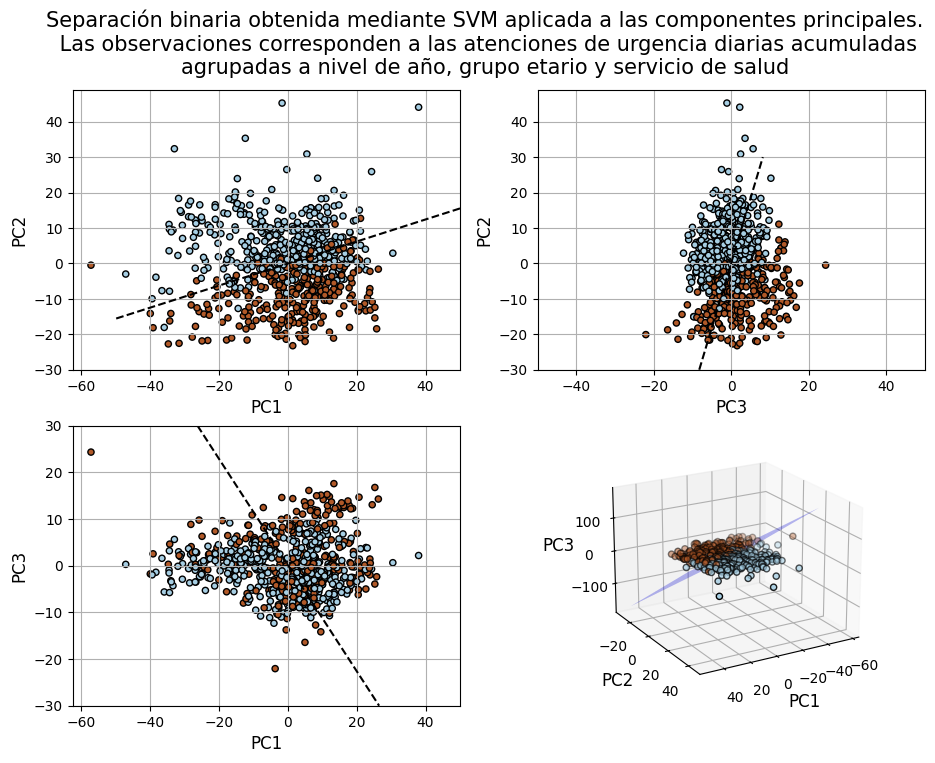

In [18]:
#Ilustracion 8:  Separación de las componentes principales usando un plano generado usando SVM
fig = plt.figure(figsize = (11,8))
fig.suptitle('Separación binaria obtenida mediante SVM aplicada a las componentes principales.\n Las observaciones corresponden a las atenciones de urgencia diarias acumuladas\nagrupadas a nivel de año, grupo etario y servicio de salud', fontsize=15)


ax = fig.add_subplot(2,2,1) 
#ax.set_title('PC1 vs PC2', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = linear_clf.decision_function([[x1, x2,0]])
    Z[i, j] = p[0]
#levels = [-1.0, 0.0, 1.0]
#linestyles = ["dashed", "solid", "dashed"]
levels = [0.0]
linestyles = ["dashed"]
colors = "k"
#ax.grid()
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=targets, cmap=plt.cm.Paired, edgecolor="black", s=20)
ax.grid()

ax = fig.add_subplot(2,2,3) 
#ax.set_title('PC1 vs PC3', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = linear_clf.decision_function([[x1, 0,x2]])
    Z[i, j] = p[0]
#levels = [-1.0, 0.0, 1.0]
#linestyles = ["dashed", "solid", "dashed"]
levels = [0.0]
linestyles = ["dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)
ax.grid()

ax = fig.add_subplot(2,2,2) 
#ax.set_title('PC2 vs PC3', fontsize = 15)
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = linear_clf.decision_function([[0, x1,x2]])
    Z[i, j] = p[0]
#levels = [-1.0, 0.0, 1.0]
#linestyles = ["dashed", "solid", "dashed"]
levels = [0.0]
linestyles = ["dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 2], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)
ax.grid()

ax = fig.add_subplot(2,2,4,projection='3d')

#ax.set_title('Binary Classification', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_zlabel('PC3', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)
zz = np.linspace(-20, 20, 10)
X1, X2, X3 = np.meshgrid(xx, yy, zz)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black")
X1, X2 = np.meshgrid(xx, yy)
ax.elev = 20
ax.azim = 60 # xy view
Zplane = -1/ linear_clf.coef_[0][2] * (linear_clf.intercept_[0]  + X1*linear_clf.coef_[0][0] + X2* linear_clf.coef_[0][1] )
ax.plot_surface(X1,X2,Zplane, color='blue',alpha=.3)

plt.savefig('fig8_binary_classification1.png', bbox_inches='tight')
#plt.show()

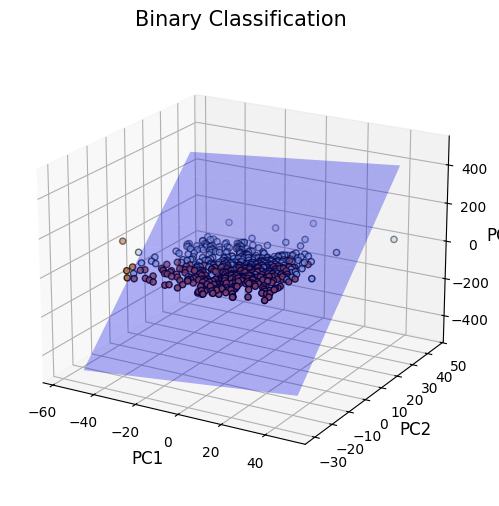

In [9]:
def generate_separating_plane(elev,azim):
    fig = plt.figure(figsize = (8,6))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Binary Classification', fontsize = 15)
    ax.set_xlabel('PC1', fontsize = 12)
    ax.set_ylabel('PC2', fontsize = 12)
    ax.set_zlabel('PC3', fontsize = 12)
    # plot the line, the points, and the nearest vectors to the plane
    xx = np.linspace(-50, 50, 10)
    yy = np.linspace(-30, 30, 10)
    zz = np.linspace(-20, 20, 10)
    X1, X2, X3 = np.meshgrid(xx, yy, zz)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black")
    X1, X2 = np.meshgrid(xx, yy)
    ax.elev = elev
    ax.azim = azim # xy view
    Zplane = -1/ linear_clf.coef_[0][2] * (linear_clf.intercept_[0]  + X1*linear_clf.coef_[0][0] + X2* linear_clf.coef_[0][1] )
    ax.plot_surface(X1,X2,Zplane, color='blue',alpha=.3)
    plt.show()
generate_separating_plane(20,-60)
#generate_separating_plane(20,-40)
#generate_separating_plane(20,-5)
#generate_separating_plane(20,40)
#generate_separating_plane(20,60)
#linear_clf.coef_
#linear_clf.intercept_

In [10]:
# Declare the group we are trying to separate

group_indices = [1,2]
targets = []
for ind in group_indices:
    if len(targets) == 0:
        targets = (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
    else:
        targets = targets | (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
X, y = finalDf[["PC1","PC2","PC3"]].values , targets 

repetitions = 1000
results=[]
for k in range(repetitions):
    # Split the dataset into a training and a testing set(20 percent)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    #print ("\nTesting Dataset Shape:", X_train.shape, y_train.shape)
    
    # Standarize the features
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # create the linear model SGDclassifier
    from sklearn.linear_model import SGDClassifier
    #linear_clf = SGDClassifier()
    linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
    
    # Train the classifier using fit() function
    linear_clf.fit(X_train, y_train)
    
    ## Print the learned coeficients
    #print ("\nThe coefficients of the linear boundary are:", linear_clf.coef_)
    #print ("\nThe point of intersection of the line are:",linear_clf.intercept_)
    
    # Evaluate the result
    
    y_train_pred = linear_clf.predict(X_train)
    #results.append(metrics.accuracy_score(y_train, y_train_pred))
    results.append(metrics.balanced_accuracy_score(y_train, y_train_pred))

print ("\nThe Accuracy of our classifier is:",np.mean(results))


The Accuracy of our classifier is: 0.8669772853083366
